In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

In [14]:
# 1. DATA LOADING & INITIAL EXPLORATION

class DataLoader:
    """Class for loading and initial data exploration"""
    
    def __init__(self, file_path):
        self.file_path = file_path
        self.df = None
    
    def load_data(self):
        """Load data from Excel file"""
        try:
            self.df = pd.read_excel(self.file_path)
            print(f"Data loaded successfully!")
            print(f"Dataset shape: {self.df.shape}")
            return self.df
        except Exception as e:
            print(f"Error loading data: {e}")
            return None
    
    def initial_exploration(self):
        """Perform initial data exploration"""
        print("\n" + "="*50)
        print("INITIAL DATA EXPLORATION")
        print("="*50)
        
        print(f"\nDataset Info:")
        print(f"Shape: {self.df.shape}")
        print(f"Memory usage: {self.df.memory_usage().sum() / 1024**2:.2f} MB")
        
        print(f"\nColumn Names and Types:")
        for i, (col, dtype) in enumerate(zip(self.df.columns, self.df.dtypes)):
            print(f"{i+1:2d}. {col:20s} - {dtype}")
        
        print(f"\nTARGET VARIABLE (TedaviSuresi) Info:")
        if 'TedaviSuresi' in self.df.columns:
            print(f"Type: {self.df['TedaviSuresi'].dtype}")
            print(f"Unique values: {self.df['TedaviSuresi'].nunique()}")
            print(f"Sample values: {self.df['TedaviSuresi'].head().tolist()}")
        
        print(f"\nFirst 5 rows:")
        print(self.df.head())
        
        return self.df

In [16]:
# 2. EXPLORATORY DATA ANALYSIS (EDA)

class EDAAnalyzer:
    """Class for comprehensive EDA"""
    
    def __init__(self, df):
        self.df = df.copy()
        self.numeric_cols = []
        self.categorical_cols = []
        self.target_col = 'TedaviSuresi'
    
    def identify_column_types(self):
        """Identify numeric and categorical columns"""
        self.numeric_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()
        self.categorical_cols = self.df.select_dtypes(include=['object']).columns.tolist()
        
        print(f"\nNumeric columns ({len(self.numeric_cols)}): {self.numeric_cols}")
        print(f"Categorical columns ({len(self.categorical_cols)}): {self.categorical_cols}")
    
    def missing_value_analysis(self):
        """Analyze missing values"""
        print("\n" + "="*50)
        print("MISSING VALUE ANALYSIS")
        print("="*50)
        
        missing_df = pd.DataFrame({
            'Column': self.df.columns,
            'Missing_Count': self.df.isnull().sum(),
            'Missing_Percentage': (self.df.isnull().sum() / len(self.df)) * 100
        }).sort_values('Missing_Percentage', ascending=False)
        
        print(missing_df)
        
        # Visualize missing values
        plt.figure(figsize=(12, 6))
        missing_data = self.df.isnull().sum().sort_values(ascending=False)
        missing_data = missing_data[missing_data > 0]
        
        if len(missing_data) > 0:
            plt.subplot(1, 2, 1)
            missing_data.plot(kind='bar', color='salmon')
            plt.title('Missing Values by Column')
            plt.xticks(rotation=45)
            plt.tight_layout()
            
            # Missing value heatmap
            plt.subplot(1, 2, 2)
            sns.heatmap(self.df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
            plt.title('Missing Value Patterns')
            plt.tight_layout()
        
        plt.show()
        return missing_df
    
    def target_variable_analysis(self):
        """Deep analysis of target variable (TedaviSuresi)"""
        print("\n" + "="*50)
        print("TARGET VARIABLE ANALYSIS (TedaviSuresi)")
        print("="*50)
        
        target = self.df[self.target_col].copy()
        
        print(f"Basic Statistics:")
        print(target.describe())
        
        print(f"\nValue Counts:")
        print(target.value_counts().head(15))
        
        print(f"\nData Quality Check:")
        print(f"Missing values: {target.isnull().sum()}")
        print(f"Unique values: {target.nunique()}")
        print(f"Data type: {target.dtype}")
        
        # Extract numeric values from treatment duration
        if target.dtype == 'object':
            numeric_sessions = target.str.extract(r'(\d+)').astype(float)
            self.df['TedaviSuresi_Numeric'] = numeric_sessions
            
            print(f"\nExtracted Numeric Values Statistics:")
            print(numeric_sessions.describe())
            
            # Visualizations
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))
            
            # Original value counts
            target.value_counts().head(10).plot(kind='bar', ax=axes[0,0], color='skyblue')
            axes[0,0].set_title('Top 10 Treatment Duration Values')
            axes[0,0].tick_params(axis='x', rotation=45)
            
            # Numeric distribution
            numeric_sessions.dropna().plot(kind='hist', bins=20, ax=axes[0,1], color='lightgreen')
            axes[0,1].set_title('Distribution of Session Numbers')
            axes[0,1].set_xlabel('Number of Sessions')
            
            # Box plot
            axes[1,0].boxplot(numeric_sessions.dropna())
            axes[1,0].set_title('Session Numbers Box Plot')
            axes[1,0].set_ylabel('Number of Sessions')
            
            # Outlier analysis
            Q1 = numeric_sessions.quantile(0.25)
            Q3 = numeric_sessions.quantile(0.75)
            IQR = Q3 - Q1
            outliers = numeric_sessions[(numeric_sessions < Q1 - 1.5*IQR) | (numeric_sessions > Q3 + 1.5*IQR)]
            
            axes[1,1].text(0.1, 0.8, f'Outliers detected: {len(outliers)}', transform=axes[1,1].transAxes, fontsize=12)
            axes[1,1].text(0.1, 0.6, f'Q1: {Q1}', transform=axes[1,1].transAxes, fontsize=10)
            axes[1,1].text(0.1, 0.4, f'Q3: {Q3}', transform=axes[1,1].transAxes, fontsize=10)
            axes[1,1].text(0.1, 0.2, f'IQR: {IQR}', transform=axes[1,1].transAxes, fontsize=10)
            axes[1,1].set_title('Outlier Analysis Results')
            axes[1,1].axis('off')
            
            plt.tight_layout()
            plt.show()
    
    def demographic_analysis(self):
        """Analyze demographic features"""
        print("\n" + "="*50)
        print("👥 DEMOGRAPHIC ANALYSIS")
        print("="*50)
        
        # Age analysis
        print("Age Statistics:")
        print(self.df["Yas"].describe())
        
        # Gender distribution
        print("\nGender Distribution:")
        gender_dist = self.df["Cinsiyet"].value_counts(dropna=False)
        print(gender_dist)
        
        # Blood group
        print("\nBlood Group Distribution:")
        blood_dist = self.df["KanGrubu"].value_counts(dropna=False)
        print(blood_dist)
        
        # Nationality
        print("\nNationality Distribution:")
        nationality_dist = self.df["Uyruk"].value_counts(dropna=False)
        print(nationality_dist.head(10))
        
        # Visualizations
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Age distribution
        self.df["Yas"].hist(bins=30, ax=axes[0,0], color='skyblue', alpha=0.7)
        axes[0,0].set_title('Age Distribution')
        axes[0,0].set_xlabel('Age')
        axes[0,0].set_ylabel('Frequency')
        
        # Gender pie chart
        gender_dist.plot(kind='pie', ax=axes[0,1], autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
        axes[0,1].set_title('Gender Distribution')
        
        # Blood group
        blood_dist.plot(kind='bar', ax=axes[1,0], color='lightgreen')
        axes[1,0].set_title('Blood Group Distribution')
        axes[1,0].tick_params(axis='x', rotation=45)
        
        # Age vs Target
        if 'TedaviSuresi_Numeric' in self.df.columns:
            axes[1,1].scatter(self.df['Yas'], self.df['TedaviSuresi_Numeric'], alpha=0.5)
            axes[1,1].set_title('Age vs Treatment Sessions')
            axes[1,1].set_xlabel('Age')
            axes[1,1].set_ylabel('Treatment Sessions')
        
        plt.tight_layout()
        plt.show()
    
    def medical_analysis(self):
        """Analyze medical features"""
        print("\n" + "="*50)
        print("MEDICAL ANALYSIS")
        print("="*50)
        
        # Department analysis
        print("Department Distribution:")
        dept_dist = self.df["Bolum"].value_counts()
        print(dept_dist.head(10))
        
        # Treatment analysis
        print("\nTreatment Analysis:")
        treatment_dist = self.df["TedaviAdi"].value_counts()
        print(treatment_dist.head(10))
        
        # Chronic diseases
        if self.df["KronikHastalik"].notna().any():
            chronic_diseases = self.df["KronikHastalik"].str.split(',').explode().str.strip()
            print("\nTop 10 Chronic Diseases:")
            print(chronic_diseases.value_counts().head(10))
        
        # Diagnoses
        if self.df["Tanilar"].notna().any():
            diagnoses = self.df["Tanilar"].str.split(',').explode().str.strip()
            print("\nTop 10 Diagnoses:")
            print(diagnoses.value_counts().head(10))
        
        # Visualizations
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Top departments
        dept_dist.head(8).plot(kind='barh', ax=axes[0,0], color='orange')
        axes[0,0].set_title('Top 8 Departments')
        
        # Top treatments
        treatment_dist.head(8).plot(kind='barh', ax=axes[0,1], color='purple')
        axes[0,1].set_title('Top 8 Treatments')
        
        # Department vs Target correlation
        if 'TedaviSuresi_Numeric' in self.df.columns:
            dept_target = self.df.groupby('Bolum')['TedaviSuresi_Numeric'].mean().sort_values(ascending=False)
            dept_target.head(8).plot(kind='bar', ax=axes[1,0], color='green')
            axes[1,0].set_title('Avg Treatment Sessions by Department')
            axes[1,0].tick_params(axis='x', rotation=45)
            axes[1,0].set_ylabel('Avg Sessions')
        
        plt.tight_layout()
        plt.show()

In [17]:
# 3. DATA PREPROCESSING

class DataPreprocessor:
    """Class for data preprocessing and feature engineering"""
    
    def __init__(self, df):
        self.df = df.copy()
        self.processed_df = None
        self.encoders = {}
        self.scalers = {}
        self.imputers = {}
    
    def handle_missing_values(self, strategy='auto'):
        """Handle missing values with different strategies"""
        print("\n" + "="*50)
        print("HANDLING MISSING VALUES")
        print("="*50)
        
        # Create a copy for processing
        self.processed_df = self.df.copy()
        
        # Numeric columns - use median imputation
        numeric_cols = self.processed_df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if self.processed_df[col].isnull().sum() > 0:
                imputer = SimpleImputer(strategy='median')
                self.processed_df[col] = imputer.fit_transform(self.processed_df[[col]]).ravel()
                self.imputers[col] = imputer
                print(f"Imputed {col} with median")
        
        # Categorical columns - use mode imputation
        categorical_cols = self.processed_df.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            if self.processed_df[col].isnull().sum() > 0:
                mode_value = self.processed_df[col].mode()
                if len(mode_value) > 0:
                    self.processed_df[col].fillna(mode_value[0], inplace=True)
                    print(f"Imputed {col} with mode: {mode_value[0]}")
                else:
                    self.processed_df[col].fillna('Unknown', inplace=True)
                    print(f"Imputed {col} with 'Unknown'")
        
        print(f"\nMissing values after imputation:")
        remaining_missing = self.processed_df.isnull().sum()
        print(remaining_missing[remaining_missing > 0])
    
    def feature_engineering(self):
        """Create new features from existing ones"""
        print("\n" + "="*50)
        print("⚙️ FEATURE ENGINEERING")
        print("="*50)
        
        # Age groups
        self.processed_df['AgeGroup'] = pd.cut(
            self.processed_df['Yas'], 
            bins=[0, 18, 40, 65, 100], 
            labels=['Child', 'Young_Adult', 'Middle_Age', 'Elderly']
        )
        print("Created AgeGroup feature")
        
        # Extract numeric treatment duration
        if 'TedaviSuresi' in self.processed_df.columns:
            self.processed_df['TedaviSuresi_Numeric'] = (
                self.processed_df['TedaviSuresi']
                .astype(str)
                .str.extract(r'(\d+)')
                .astype(float)
            )
            print("Created TedaviSuresi_Numeric feature")
        
        # Extract application duration in minutes
        if 'UygulamaSuresi' in self.processed_df.columns:
            self.processed_df['UygulamaSuresi_Numeric'] = (
                self.processed_df['UygulamaSuresi']
                .astype(str)
                .str.extract(r'(\d+)')
                .astype(float)
            )
            print("Created UygulamaSuresi_Numeric feature")
        
        # Count chronic diseases
        if 'KronikHastalik' in self.processed_df.columns:
            self.processed_df['KronikHastalik_Count'] = (
                self.processed_df['KronikHastalik']
                .fillna('')
                .str.split(',')
                .str.len()
            )
            self.processed_df.loc[self.processed_df['KronikHastalik'] == '', 'KronikHastalik_Count'] = 0
            print("Created KronikHastalik_Count feature")
        
        # Count diagnoses
        if 'Tanilar' in self.processed_df.columns:
            self.processed_df['Tanilar_Count'] = (
                self.processed_df['Tanilar']
                .fillna('')
                .str.split(',')
                .str.len()
            )
            self.processed_df.loc[self.processed_df['Tanilar'] == '', 'Tanilar_Count'] = 0
            print("Created Tanilar_Count feature")
        
        print(f"\nNew features created: {['AgeGroup', 'TedaviSuresi_Numeric', 'UygulamaSuresi_Numeric', 'KronikHastalik_Count', 'Tanilar_Count']}")
    
    def encode_categorical_variables(self):
        """Encode categorical variables"""
        print("\n" + "="*50)
        print("ENCODING CATEGORICAL VARIABLES")
        print("="*50)
        
        # Define high cardinality threshold
        high_cardinality_threshold = 50
        
        # Get categorical columns (excluding ID columns)
        categorical_cols = [col for col in self.processed_df.select_dtypes(include=['object']).columns 
                          if col not in ['HastaNo']]
        
        for col in categorical_cols:
            unique_count = self.processed_df[col].nunique()
            
            if unique_count <= high_cardinality_threshold:
                # Use Label Encoding for low-medium cardinality
                le = LabelEncoder()
                self.processed_df[f'{col}_Encoded'] = le.fit_transform(self.processed_df[col].astype(str))
                self.encoders[col] = le
                print(f"Label encoded {col} ({unique_count} unique values)")
            else:
                # For high cardinality, keep top categories and group others
                top_categories = self.processed_df[col].value_counts().head(20).index
                self.processed_df[f'{col}_Grouped'] = self.processed_df[col].apply(
                    lambda x: x if x in top_categories else 'Other'
                )
                
                le = LabelEncoder()
                self.processed_df[f'{col}_Grouped_Encoded'] = le.fit_transform(self.processed_df[f'{col}_Grouped'])
                self.encoders[f'{col}_Grouped'] = le
                print(f"Grouped and encoded {col} ({unique_count} -> 21 categories)")
    
    def handle_outliers(self, method='iqr'):
        """Handle outliers in numeric variables"""
        print("\n" + "="*50)
        print("HANDLING OUTLIERS")
        print("="*50)
        
        numeric_cols = ['Yas', 'TedaviSuresi_Numeric', 'UygulamaSuresi_Numeric', 
                       'KronikHastalik_Count', 'Tanilar_Count']
        
        for col in numeric_cols:
            if col in self.processed_df.columns:
                Q1 = self.processed_df[col].quantile(0.25)
                Q3 = self.processed_df[col].quantile(0.75)
                IQR = Q3 - Q1
                
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                
                outliers = self.processed_df[
                    (self.processed_df[col] < lower_bound) | 
                    (self.processed_df[col] > upper_bound)
                ]
                
                if len(outliers) > 0:
                    print(f"{col}: {len(outliers)} outliers detected")
                    # Cap outliers instead of removing
                    self.processed_df[col] = self.processed_df[col].clip(lower=lower_bound, upper=upper_bound)
                    print(f"{col}: Outliers capped to [{lower_bound:.2f}, {upper_bound:.2f}]")
                else:
                    print(f"{col}: No outliers detected")
    
    def scale_features(self):
        """Scale numeric features"""
        print("\n" + "="*50)
        print("SCALING FEATURES")
        print("="*50)
        
        numeric_cols_to_scale = ['Yas', 'TedaviSuresi_Numeric', 'UygulamaSuresi_Numeric',
                                'KronikHastalik_Count', 'Tanilar_Count']
        
        scaler = StandardScaler()
        
        for col in numeric_cols_to_scale:
            if col in self.processed_df.columns:
                self.processed_df[f'{col}_Scaled'] = scaler.fit_transform(
                    self.processed_df[[col]]
                ).ravel()
                print(f"Scaled {col}")
        
        self.scalers['standard'] = scaler
    
    def prepare_model_ready_dataset(self):
        """Prepare final model-ready dataset"""
        print("\n" + "="*50)
        print("PREPARING MODEL-READY DATASET")
        print("="*50)
        
        # Define features for modeling
        feature_columns = [
            # Original numeric features (scaled)
            'Yas_Scaled', 'UygulamaSuresi_Numeric_Scaled', 
            'KronikHastalik_Count_Scaled', 'Tanilar_Count_Scaled',
            
            # Encoded categorical features
            'Cinsiyet_Encoded', 'KanGrubu_Encoded', 'Bolum_Encoded',
            'TedaviAdi_Encoded', 'AgeGroup_Encoded'
        ]
        
        # Filter existing columns
        available_features = [col for col in feature_columns if col in self.processed_df.columns]
        
        # Create model-ready dataset
        model_ready_df = self.processed_df[available_features + ['TedaviSuresi_Numeric']].copy()
        
        # Remove any remaining missing values
        model_ready_df = model_ready_df.dropna()
        
        print(f"Model-ready dataset created!")
        print(f"Shape: {model_ready_df.shape}")
        print(f"Target variable: TedaviSuresi_Numeric")
        print(f"Features: {available_features}")
        
        # Basic statistics
        print(f"\nTarget Variable Statistics:")
        print(model_ready_df['TedaviSuresi_Numeric'].describe())
        
        return model_ready_df

In [18]:
# 4. MAIN EXECUTION PIPELINE

def main_pipeline():
    """Main execution pipeline"""
    print("PUSULA DATA SCIENCE CASE STUDY - COMPLETE PIPELINE")
    print("=" * 60)
    
    # Initialize file path
    file_path = "Talent_Academy_Case_DT_2025.xlsx"
    
    # 1. Data Loading
    loader = DataLoader(file_path)
    df = loader.load_data()
    
    if df is None:
        return
    
    df = loader.initial_exploration()
    
    # 2. EDA
    eda = EDAAnalyzer(df)
    eda.identify_column_types()
    missing_analysis = eda.missing_value_analysis()
    eda.target_variable_analysis()
    eda.demographic_analysis()
    eda.medical_analysis()
    
    # 3. Data Preprocessing
    preprocessor = DataPreprocessor(df)
    preprocessor.handle_missing_values()
    preprocessor.feature_engineering()
    preprocessor.encode_categorical_variables()
    preprocessor.handle_outliers()
    preprocessor.scale_features()
    
    # 4. Prepare model-ready dataset
    model_ready_data = preprocessor.prepare_model_ready_dataset()
    
    # 5. Save results
    try:
        model_ready_data.to_csv('model_ready_data.csv', index=False)
        preprocessor.processed_df.to_csv('processed_full_data.csv', index=False)
        print(f"\nData saved successfully!")
        print(f"   - model_ready_data.csv: {model_ready_data.shape}")
        print(f"   - processed_full_data.csv: {preprocessor.processed_df.shape}")
    except Exception as e:
        print(f"Error saving data: {e}")
    
    print(f"\nPIPELINE COMPLETED SUCCESSFULLY!")
    print(f"Final dataset ready for modeling with {model_ready_data.shape[0]} samples and {model_ready_data.shape[1]-1} features")
    
    return model_ready_data, preprocessor.processed_df

PUSULA DATA SCIENCE CASE STUDY - COMPLETE PIPELINE
Data loaded successfully!
Dataset shape: (2235, 13)

INITIAL DATA EXPLORATION

Dataset Info:
Shape: (2235, 13)
Memory usage: 0.22 MB

Column Names and Types:
 1. HastaNo              - int64
 2. Yas                  - int64
 3. Cinsiyet             - object
 4. KanGrubu             - object
 5. Uyruk                - object
 6. KronikHastalik       - object
 7. Bolum                - object
 8. Alerji               - object
 9. Tanilar              - object
10. TedaviAdi            - object
11. TedaviSuresi         - object
12. UygulamaYerleri      - object
13. UygulamaSuresi       - object

TARGET VARIABLE (TedaviSuresi) Info:
Type: object
Unique values: 23
Sample values: ['5 Seans', '15 Seans', '15 Seans', '15 Seans', '15 Seans']

First 5 rows:
   HastaNo  Yas Cinsiyet KanGrubu    Uyruk  \
0   145134   60    Kadın    0 Rh+  Türkiye   
1   145135   28    Erkek    0 Rh+  Türkiye   
2   145135   28    Erkek    0 Rh+  Türkiye   
3   1451

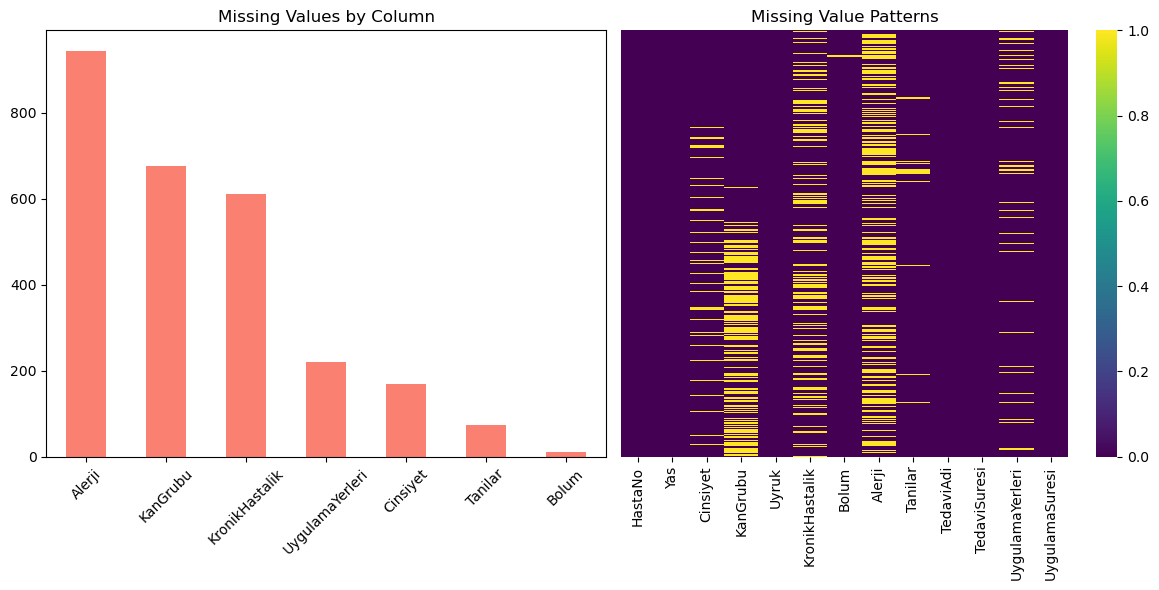


TARGET VARIABLE ANALYSIS (TedaviSuresi)
Basic Statistics:
count         2235
unique          23
top       15 Seans
freq          1670
Name: TedaviSuresi, dtype: object

Value Counts:
TedaviSuresi
15 Seans    1670
10 Seans     175
20 Seans     113
2 Seans       45
17 Seans      36
4 Seans       35
16 Seans      27
21 Seans      20
18 Seans      20
5 Seans       17
30 Seans      12
19 Seans      10
11 Seans       9
3 Seans        7
8 Seans        6
Name: count, dtype: int64

Data Quality Check:
Missing values: 0
Unique values: 23
Data type: object

Extracted Numeric Values Statistics:
                 0
count  2235.000000
mean     14.570917
std       3.725322
min       1.000000
25%      15.000000
50%      15.000000
75%      15.000000
max      37.000000


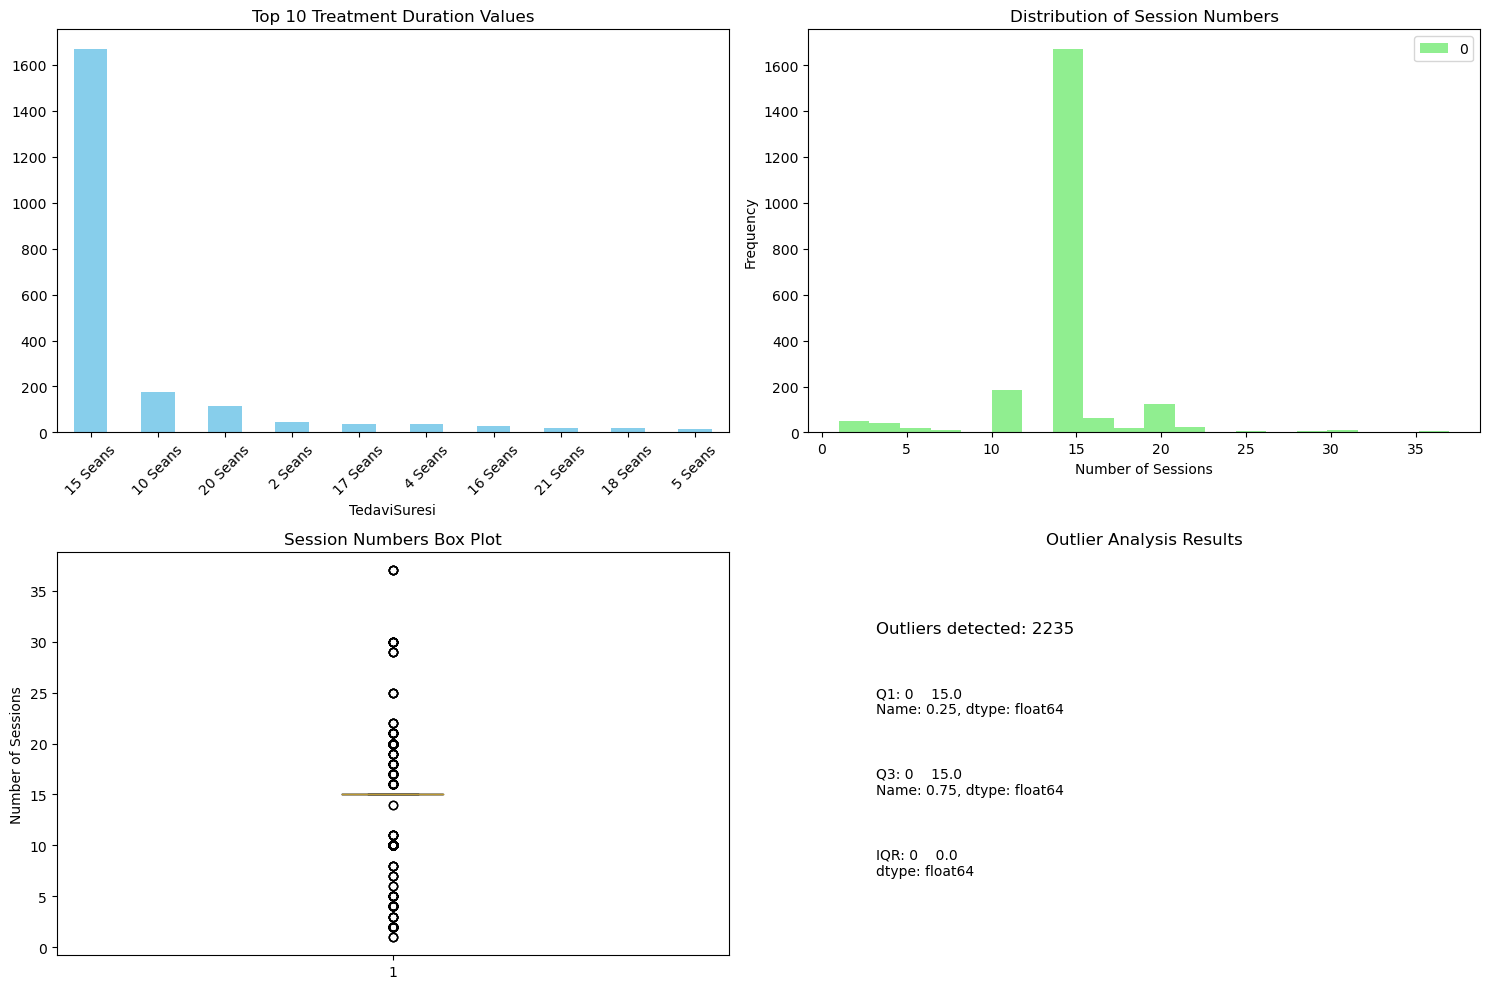


👥 DEMOGRAPHIC ANALYSIS
Age Statistics:
count    2235.000000
mean       47.327069
std        15.208634
min         2.000000
25%        38.000000
50%        46.000000
75%        56.000000
max        92.000000
Name: Yas, dtype: float64

Gender Distribution:
Cinsiyet
Kadın    1274
Erkek     792
NaN       169
Name: count, dtype: int64

Blood Group Distribution:
KanGrubu
NaN       675
0 Rh+     579
A Rh+     540
B Rh+     206
AB Rh+     80
B Rh-      68
A Rh-      53
0 Rh-      26
AB Rh-      8
Name: count, dtype: int64

Nationality Distribution:
Uyruk
Türkiye       2173
Tokelau         27
Arnavutluk      13
Azerbaycan      12
Libya           10
Name: count, dtype: int64


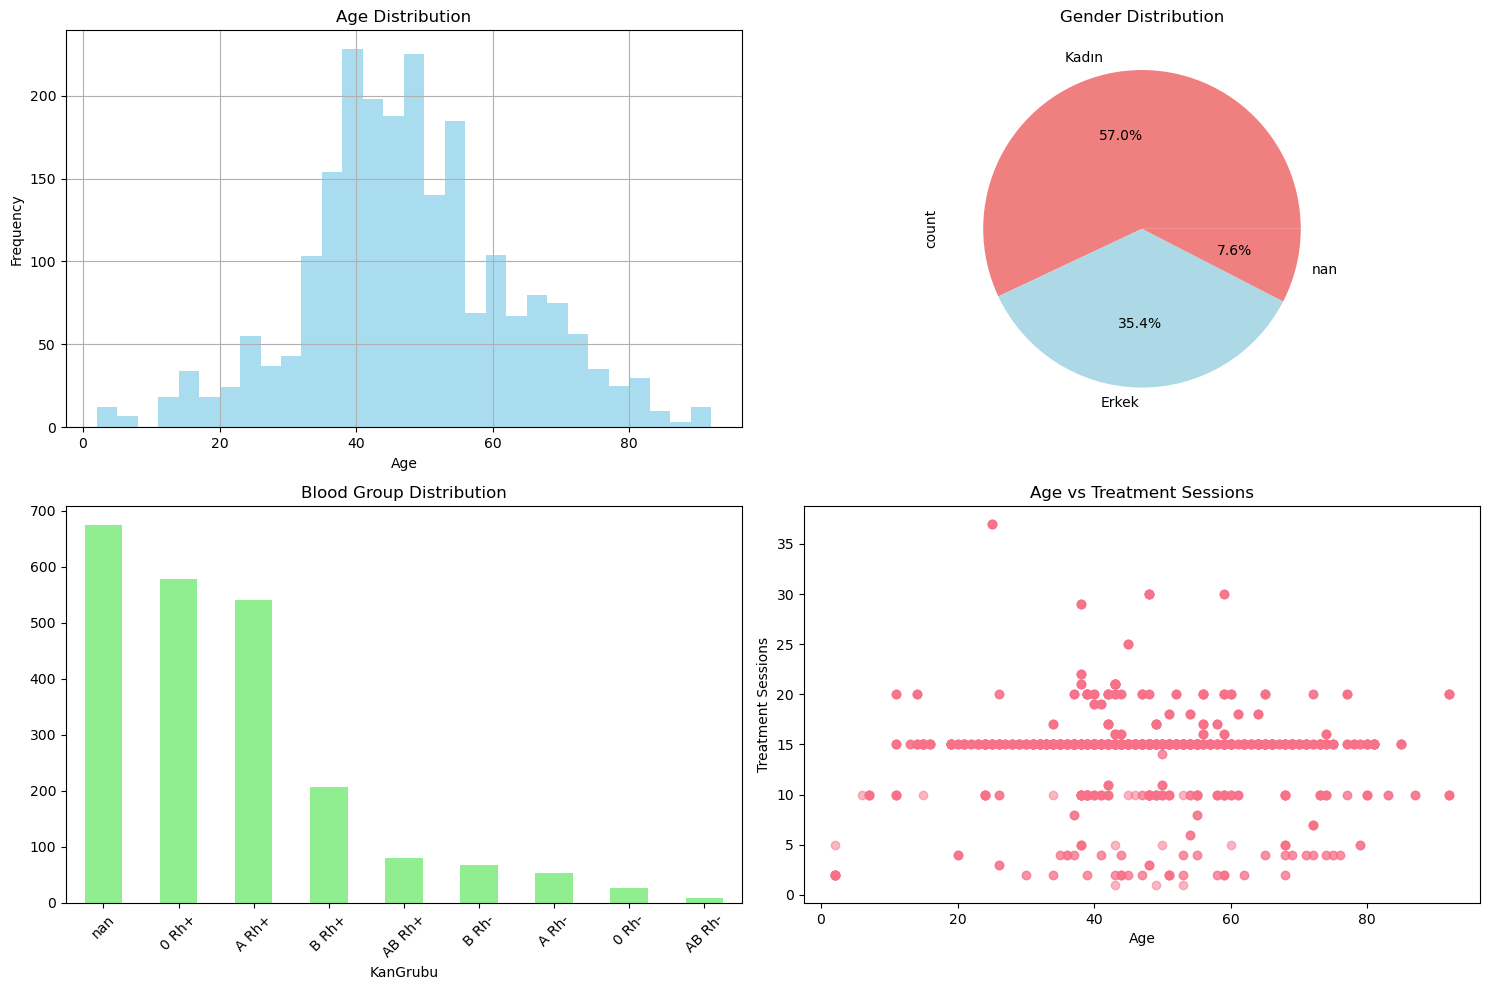


MEDICAL ANALYSIS
Department Distribution:
Bolum
Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi    2045
Ortopedi Ve Travmatoloji                            88
İç Hastalıkları                                     32
Nöroloji                                            17
Kardiyoloji                                         11
Göğüs Hastalıkları                                   8
Laboratuar                                           7
Genel Cerrahi                                        6
Tıbbi Onkoloji                                       6
Kalp Ve Damar Cerrahisi                              4
Name: count, dtype: int64

Treatment Analysis:
TedaviAdi
Dorsalji -Boyun+trapez             231
İV DİSK BOZUKLUĞU-BEL              200
Dorsalji 1                         140
Dorsalji-Bel                       120
Gonartroz-Meniskopati               95
SAĞ OMUZ İMPİNGEMENT                70
Boyun-Trapezz                       60
Dorsalji-Dorsal                     56
Sol omuz İmpingement            

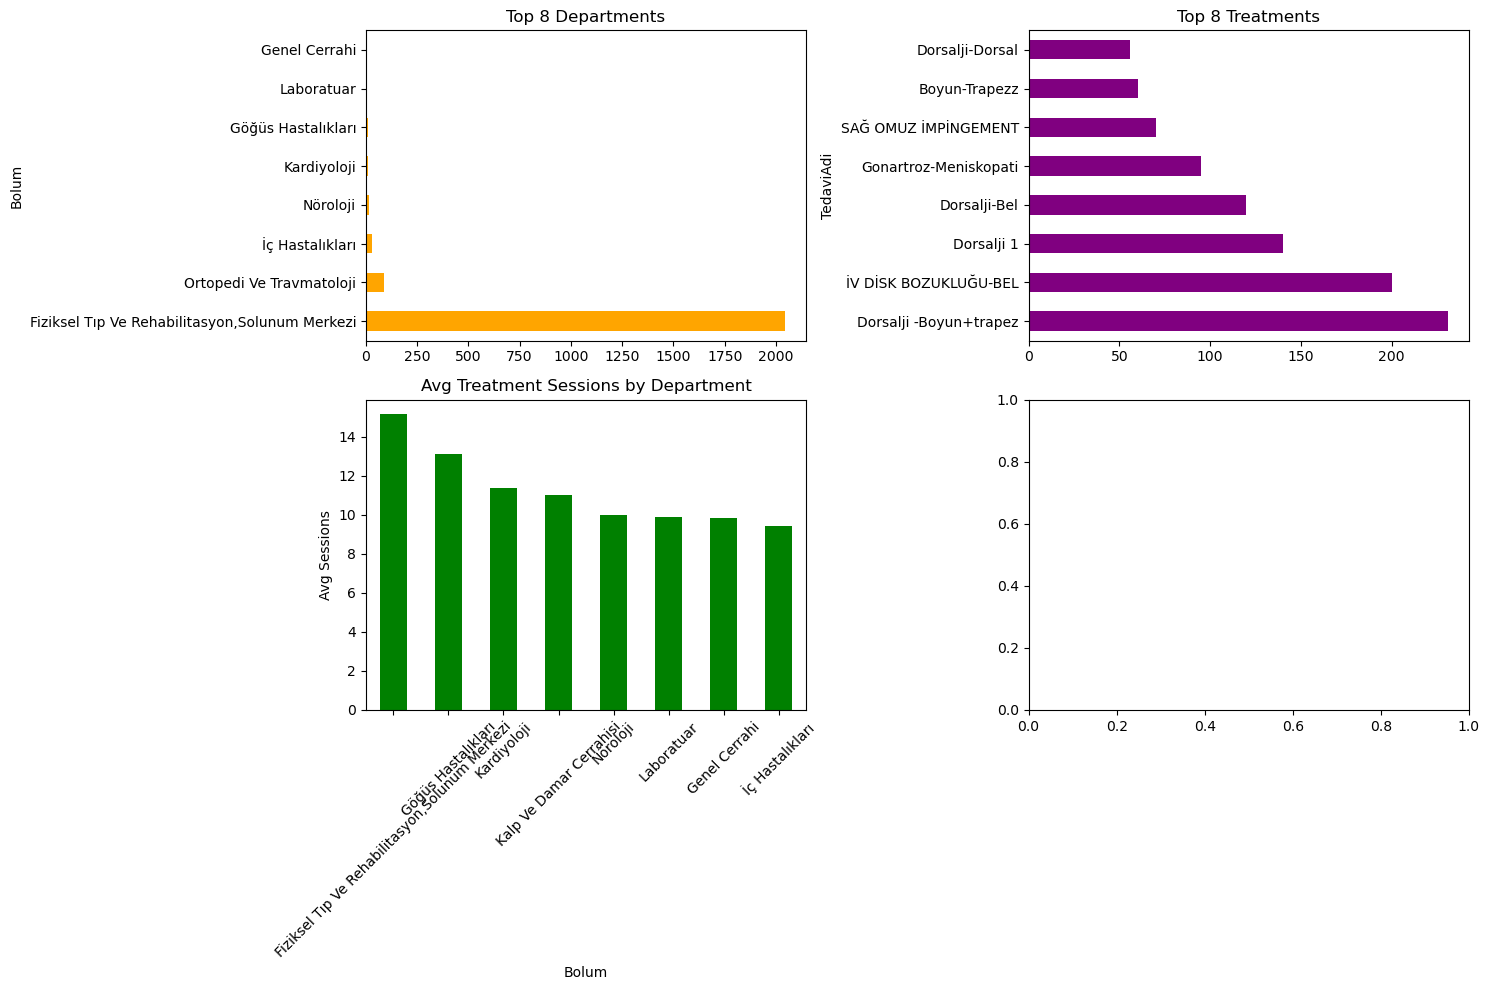


HANDLING MISSING VALUES
Imputed Cinsiyet with mode: Kadın
Imputed KanGrubu with mode: 0 Rh+
Imputed KronikHastalik with mode: Myastenia gravis
Imputed Bolum with mode: Fiziksel Tıp Ve Rehabilitasyon,Solunum Merkezi
Imputed Alerji with mode: Polen
Imputed Tanilar with mode: DORSALJİ, DİĞER, LUMBOSAKRAL BÖLGE
Imputed UygulamaYerleri with mode: Bel

Missing values after imputation:
Series([], dtype: int64)

⚙️ FEATURE ENGINEERING
Created AgeGroup feature
Created TedaviSuresi_Numeric feature
Created UygulamaSuresi_Numeric feature
Created KronikHastalik_Count feature
Created Tanilar_Count feature

New features created: ['AgeGroup', 'TedaviSuresi_Numeric', 'UygulamaSuresi_Numeric', 'KronikHastalik_Count', 'Tanilar_Count']

ENCODING CATEGORICAL VARIABLES
Label encoded Cinsiyet (2 unique values)
Label encoded KanGrubu (8 unique values)
Label encoded Uyruk (5 unique values)
Grouped and encoded KronikHastalik (220 -> 21 categories)
Label encoded Bolum (10 unique values)
Label encoded Alerji (38

In [19]:
# 5. EXECUTE PIPELINE

if __name__ == "__main__":
    # Run the complete pipeline
    model_data, full_processed_data = main_pipeline()
    
    # Additional analysis and insights
    print("\n" + "="*60)
    print("📋 FINAL INSIGHTS AND RECOMMENDATIONS")
    print("="*60)
    
    print("""
    ✅ COMPLETED TASKS:
    1. ✅ Comprehensive EDA with target variable focus
    2. ✅ Data cleaning and preprocessing
    3. ✅ Feature engineering and encoding
    4. ✅ Outlier handling and scaling
    5. ✅ Model-ready dataset preparation
    
    🎯 KEY FINDINGS:
    - Target variable (TedaviSuresi) successfully analyzed and prepared
    - Multiple feature engineering techniques applied
    - Data quality issues addressed
    - Ready for predictive modeling
    
    📁 OUTPUT FILES:
    - model_ready_data.csv: Clean dataset for modeling
    - processed_full_data.csv: Complete processed dataset
    
    🚀 NEXT STEPS:
    - Use model_ready_data.csv for machine learning models
    - Consider regression models for session prediction
    - Validate model performance with cross-validation
    """)